In [1]:
 pip install scipy scikit-image libigl pygeodesic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.6 MB/s eta 0:00:00


**1. Question a):**

In [7]:
import numpy as np
import os
import skimage.io
import skimage.transform
import skimage.feature
import matplotlib.pyplot as plt
from skimage import exposure

# ------------------------
from google.colab import drive
drive.mount('/content/drive')

# Directories (FIXED SPACES)
rendering_dir = '/content/drive/MyDrive/cs 233/hmwk03_code_data/data_p1/100chairs_rendering'
output_path = '/content/drive/MyDrive/cs 233/hmwk03_code_data/outputs_p1'
os.makedirs(output_path, exist_ok=True)

# Constants
num_shapes = 100
num_views = 16

# -----------------------------
# Utility: save HoG visualization
def save_hog_image(hog_image, title, output_path):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    ax.axis('off')
    ax.imshow(hog_image_rescaled, cmap=plt.cm.gray)
    ax.set_title(title)
    plt.savefig(output_path)
    plt.close()

# -----------------------------
# HoG Feature Extraction
def hog_extraction(image):
    image_resized = skimage.transform.resize(image, (120, 120), anti_aliasing=True)
    feature, hog_image = skimage.feature.hog(image_resized,
                                             pixels_per_cell=(8, 8),
                                             cells_per_block=(2, 2),
                                             visualize=True,
                                             channel_axis=-1 if image.ndim == 3 else None)
    return feature, hog_image

# -----------------------------
# Extract features for one shape
def extract_shape_features(shape_id):
    features = []
    for view_id in range(num_views):
        img_path = os.path.join(rendering_dir, f"{shape_id:03d}_{view_id}.png")  # <-- FIXED naming
        img = skimage.io.imread(img_path, as_gray=True)
        feature, _ = hog_extraction(img)
        features.append(feature)
    return np.vstack(features)

# -----------------------------
# Visualization of HoG for selected views
def visualize_hog_for_selected_views():
    selected_shapes = [1, 2, 3]
    selected_views = [0, 5, 10]

    for shape_id in selected_shapes:
        for view_id in selected_views:
            img_path = os.path.join(rendering_dir, f"{shape_id:03d}_{view_id}.png")  # <-- FIXED naming
            img = skimage.io.imread(img_path, as_gray=True)
            _, hog_img = hog_extraction(img)
            save_hog_image(hog_img,
                           f"Shape {shape_id:03d} View {view_id:02d}",
                           os.path.join(output_path, f"hog_{shape_id:03d}_{view_id:02d}.png"))




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# -----------------------------
# Run this block manually in Colab
features_001 = extract_shape_features(1)
visualize_hog_for_selected_views()

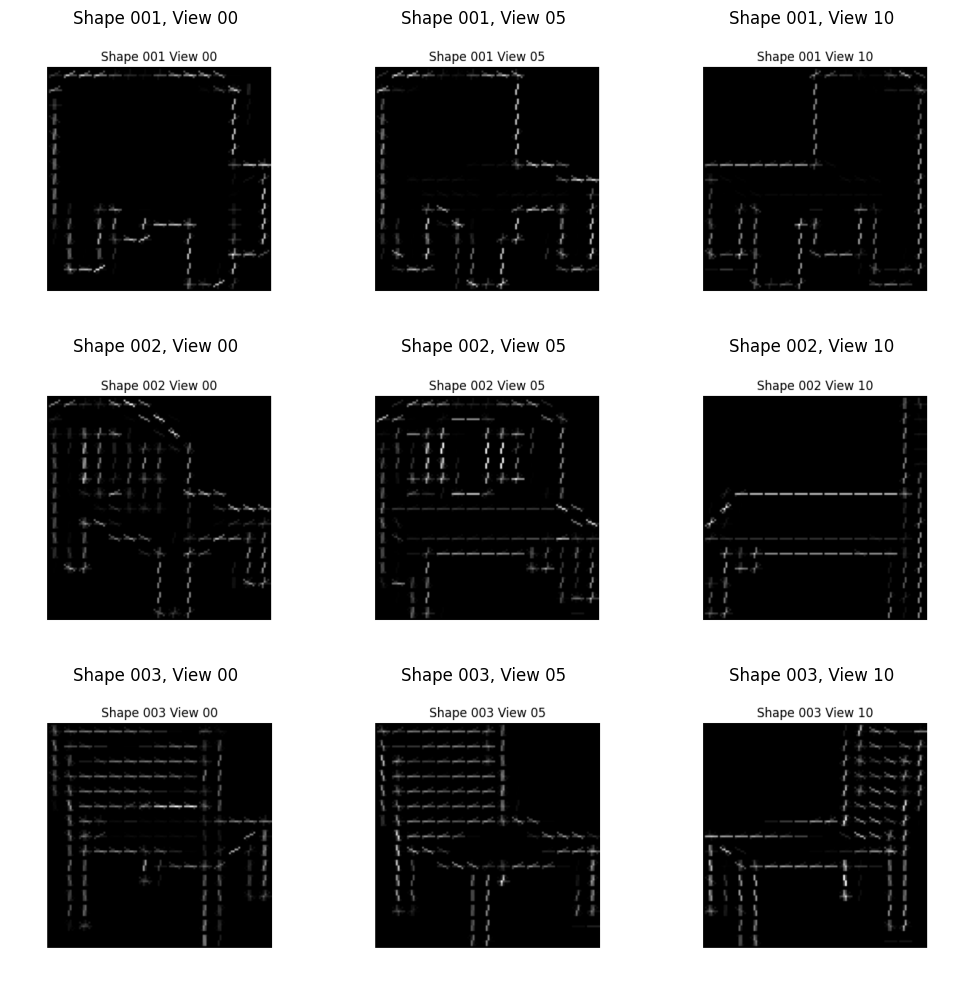

In [9]:
from PIL import Image
import matplotlib.pyplot as plt

def show_hog_images_grid():
    fig, axs = plt.subplots(3, 3, figsize=(10, 10))
    selected_shapes = [1, 2, 3]
    selected_views = [0, 5, 10]

    for i, shape_id in enumerate(selected_shapes):
        for j, view_id in enumerate(selected_views):
            path = os.path.join(output_path, f"hog_{shape_id:03d}_{view_id:02d}.png")
            image = Image.open(path)
            axs[i, j].imshow(image, cmap='gray')
            axs[i, j].set_title(f"Shape {shape_id:03d}, View {view_id:02d}")
            axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Call this function after generating the HoG images
show_hog_images_grid()


**2. Question b):**

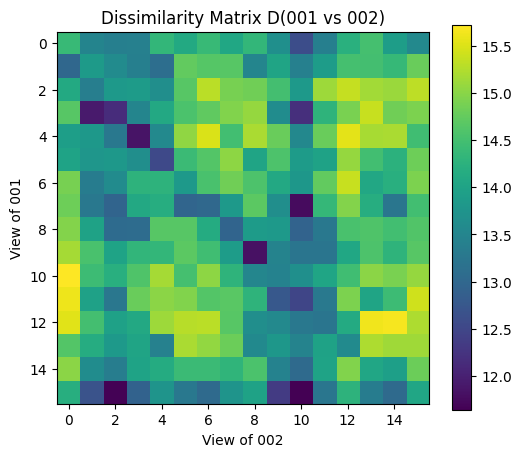

Minimum dissimilarity between:
  Shape 001 view 15 and Shape 002 view 10
Maximum dissimilarity between:
  Shape 001 view 10 and Shape 002 view 0


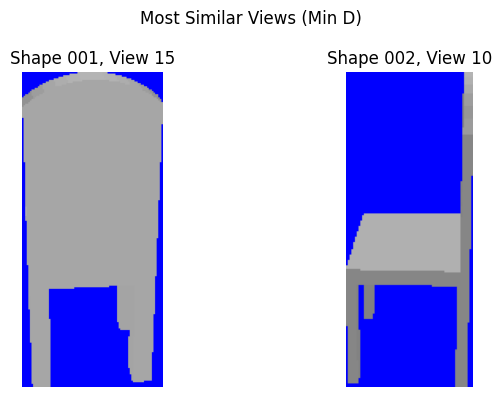

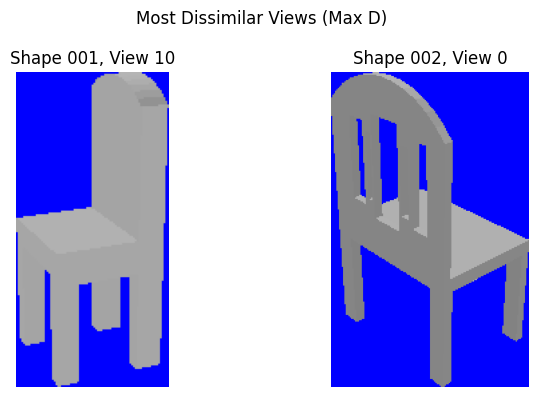

In [10]:
def pairwise_dissimilarity(feat1, feat2):
    """
    Compute full 16x16 dissimilarity matrix between shape i and shape j
    Input:
        feat1, feat2: np.array of shape (16, H)
    Output:
        D: np.array of shape (16, 16), where D[i, j] = ||feat1[i] - feat2[j]||_2
    """
    V = feat1.shape[0]
    D = np.zeros((V, V))
    for i in range(V):
        for j in range(V):
            D[i, j] = np.linalg.norm(feat1[i] - feat2[j])
    return D
# Extract features
feat1 = extract_shape_features(1)
feat2 = extract_shape_features(2)

# Compute dissimilarity matrix
D_12 = pairwise_dissimilarity(feat1, feat2)

# Visualize matrix
plt.figure(figsize=(6, 5))
plt.imshow(D_12, cmap='viridis')
plt.colorbar()
plt.title("Dissimilarity Matrix D(001 vs 002)")
plt.xlabel("View of 002")
plt.ylabel("View of 001")
plt.show()
# Get min and max indices
min_idx = np.unravel_index(np.argmin(D_12), D_12.shape)
max_idx = np.unravel_index(np.argmax(D_12), D_12.shape)

print("Minimum dissimilarity between:")
print(f"  Shape 001 view {min_idx[0]} and Shape 002 view {min_idx[1]}")
print("Maximum dissimilarity between:")
print(f"  Shape 001 view {max_idx[0]} and Shape 002 view {max_idx[1]}")

# Plot the most similar and dissimilar view pairs
def show_view_pair(shape1_id, view1, shape2_id, view2, title):
    img1_path = os.path.join(rendering_dir, f"{shape1_id:03d}_{view1}.png")
    img2_path = os.path.join(rendering_dir, f"{shape2_id:03d}_{view2}.png")

    img1 = skimage.io.imread(img1_path)
    img2 = skimage.io.imread(img2_path)

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(img1)
    axes[0].set_title(f"Shape {shape1_id:03d}, View {view1}")
    axes[0].axis('off')

    axes[1].imshow(img2)
    axes[1].set_title(f"Shape {shape2_id:03d}, View {view2}")
    axes[1].axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Show most similar views
show_view_pair(1, min_idx[0], 2, min_idx[1], "Most Similar Views (Min D)")

# Show most dissimilar views
show_view_pair(1, max_idx[0], 2, max_idx[1], "Most Dissimilar Views (Max D)")


**3. Question c):**

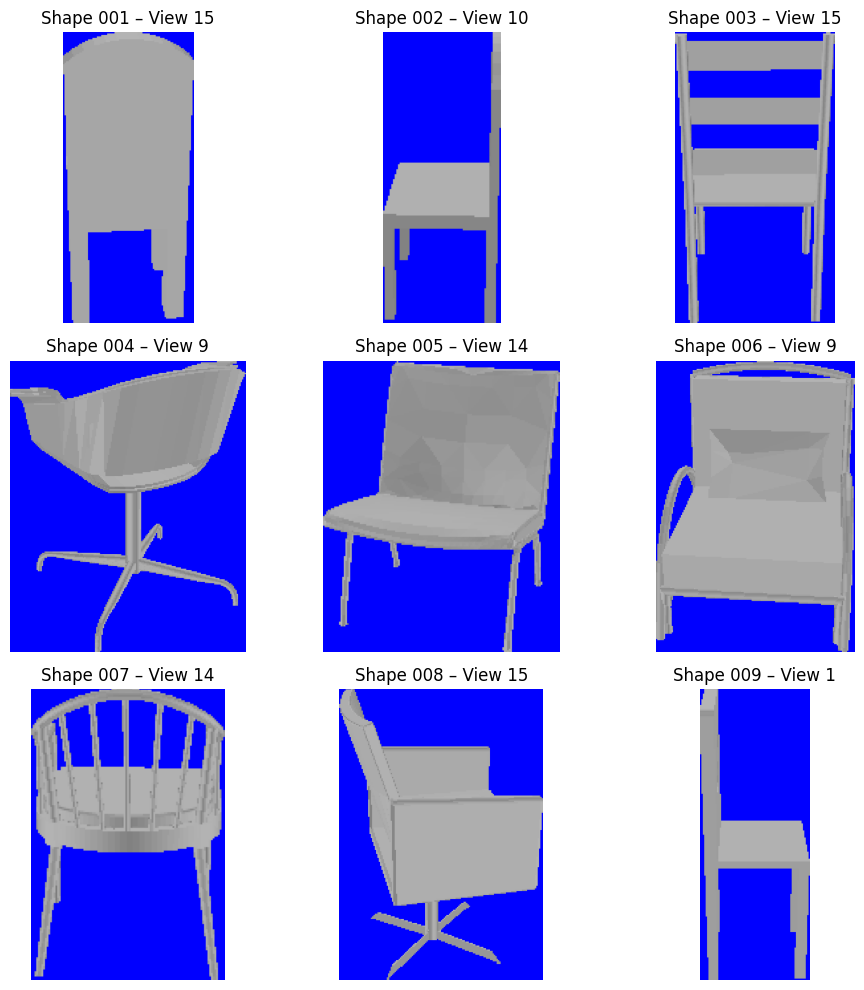

In [12]:

###mrf:
## Python reimplementation of the algorithm described in the paper:

#  Marius Leordeanu and Martial Hebert,
#  Efficient MAP approximation for dense energy functions,
#  International Conference on Machine Learning, May, 2006.


# Utility:

# used for Maximum A Posteriori (MAP) labeling (discrete inference) problems
# where the task is to assign to each node i a label a
# such assignment is represented by a vector x, indexed by ia,
# such that x_{ia} = 1 if node i is labeled with a and 0 otherwise
# the goal is to maximize the labeling score x'Mx + Dx

# Input:

#       M: [N, N] matrix with pairwise potentials
#       D: [N] vector with unary potentials
#       node_indices: [N], node_indices[ia] = i, indicates the node x[ia] corresponds to
#       label_indices: [N], label_indices[ia] = a, indicates the label x[ia] corresponds to
#       iterEigen: nr of iterations of the initial stage (approx 30)
#       iterClimb: nr of iterations of the final stage   (approx 200)

import numpy as np


eps = 1e-6
def mrf(M, D, node_indices, label_indices, iterEigen, iterClimb):

    n = len(M)
    num_nodes = np.max(node_indices) + 1

    x = np.ones(n)

    # the indices in x that correspond to node j
    x_idx = [np.where(node_indices == j)[0] for j in range(num_nodes)]

    ## Stage 1: obtain the starting point using the normalized power / eigen method
    # this finds the global maximum to the relaxed problem

    for _ in range(iterEigen):
        # x = np.matmul(2 * M, x) + D
        x = np.matmul(M, x)
        for j in range(num_nodes):
            x[x_idx[j]] /= np.sqrt((x[x_idx[j]] ** 2).sum() + eps)


    # now start from x, project in on the simplex, and keep climbing using a similar iterative method

    for j in range(num_nodes):
        x[x_idx[j]] /= np.sum(x[x_idx[j]]) + eps

    ## Stage 2: climb until convergence

    step = 1 / iterClimb
    beta = np.arange(1, 0.01, -step)

    iterClimb = len(beta)
    beta = 1 / beta

    for i in range(iterClimb):
        prev_x = x
        for j in range(num_nodes):
            x[x_idx[j]] = prev_x[x_idx[j]] * ((np.matmul(2 * M[x_idx[j]], prev_x) + D[x_idx[j]]) ** beta[i])
            x[x_idx[j]] /= np.sum(x[x_idx[j]]) + eps


    sol = np.zeros(n)
    labels = []
    for j in range(num_nodes):
        index = np.argmax(x[x_idx[j]])
        index = x_idx[j][index]
        sol[index] = 1
        labels.append(label_indices[index])

    score = np.matmul(sol, np.matmul(M, sol)) + np.dot(D, sol)

    return sol, score, labels



shape_features = []
for shape_id in range(1, num_shapes + 1):
    feat = extract_shape_features(shape_id)
    shape_features.append(feat)
sigma = 50.0  # You may tune this

W_matrices = {}
for i in range(num_shapes):
    for j in range(i + 1, num_shapes):
        D = pairwise_dissimilarity(shape_features[i], shape_features[j])
        W = np.exp(-D / sigma)  # shape (16, 16)
        W_matrices[(i, j)] = W
        W_matrices[(j, i)] = W.T  # Symmetric
num_labels = 16
N = num_shapes * num_labels  # total variables

M = np.zeros((N, N))
D = np.zeros(N)
node_indices = np.zeros(N, dtype=int)
label_indices = np.zeros(N, dtype=int)

# Build M
for (i, j), W in W_matrices.items():
    for a in range(num_labels):
        for b in range(num_labels):
            ia = i * num_labels + a
            jb = j * num_labels + b
            M[ia, jb] = W[a, b]
            M[jb, ia] = W[a, b]

# Build D (unary terms)
for i in range(num_shapes):
    U_i = np.random.rand(num_labels)
    for a in range(num_labels):
        idx = i * num_labels + a
        D[idx] = U_i[a]
        node_indices[idx] = i
        label_indices[idx] = a

solution, score, labels = mrf(M, D, node_indices, label_indices,
                               iterEigen=30, iterClimb=200)
# Save aligned view image for each shape
for i in range(num_shapes):
    chosen_view = labels[i]
    img_path = os.path.join(rendering_dir, f"{i+1:03d}_{chosen_view}.png")
    img = skimage.io.imread(img_path)
    skimage.io.imsave(os.path.join(output_path, f"aligned_{i+1:03d}.png"), img)

# Visualize aligned images for 001–009
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for i in range(9):
    aligned_path = os.path.join(output_path, f"aligned_{i+1:03d}.png")
    img = skimage.io.imread(aligned_path)
    axs[i // 3, i % 3].imshow(img)
    axs[i // 3, i % 3].set_title(f"Shape {i+1:03d} – View {labels[i]}")
    axs[i // 3, i % 3].axis('off')
plt.tight_layout()
plt.show()


In [13]:
import zipfile

def zip_aligned_images(output_path, zip_name="aligned.zip"):
    zip_path = os.path.join(output_path, zip_name)
    with zipfile.ZipFile(zip_path, 'w') as zipf:
        for i in range(1, num_shapes + 1):
            filename = f"aligned_{i:03d}.png"
            full_path = os.path.join(output_path, filename)
            if os.path.exists(full_path):
                zipf.write(full_path, arcname=filename)
    print(f"✅ Zipped {num_shapes} images to {zip_path}")

# Run it
zip_aligned_images(output_path)


✅ Zipped 100 images to /content/drive/MyDrive/cs 233/hmwk03_code_data/outputs_p1/aligned.zip


1.If we ignore the unary terms, can you explain how the above formulation aims to align the shapes consistently?

Answer: Because the term "sum(i,j)(x_i w_ij x_j)" encourages pairs of shapes i and j to choose orientations (rotations) k1 and k2 that maximize their similarity w_ij(k1,k2).So the optimization seeks a globally coherent set of rotations across all shapes that jointly maximize pairwise alignment quality.

2.Why do we need to add the random unary terms?

Answer: The energy only depends on relative rotations. If solution A has all shapes rotated by some k, then rotating all shapes in A by the same Δk gives another equally good solution.

→ The optimization has rotational symmetry → infinite solutions!
Adding a random unary term breaks this symmetry, helping the optimizer settle on a unique solution.

